In [1]:
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
# from octo.utils.jax_utils import initialize_compilation_cache

import tensorflow as tf
# initialize_compilation_cache()
# # prevent tensorflow from using GPU memory since it's only used for data loading
tf.config.set_visible_devices([], "GPU")


/root/miniconda3/envs/octo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-22 10:39:05.714520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 10:39:05.714554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 10:39:05.715865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 10:39:06.667590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Coul

## 1.不训练测试：

In [2]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
from huggingface_hub import hf_hub_download
from octo.model.octo_model import OctoModel
model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small-1.5")
# model = OctoModel.load_pretrained("/root/autodl-tmp/model/")
print('Successfully!')

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 65879.12it/s]


Successfully!


In [3]:
# # create RLDS dataset builder
# builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
# ds = builder.as_dataset(split='train[:1]')
# 创建数据集构建器，使用本地路径
# builder = tfds.builder_from_directory(builder_dir='/root/octo/examples/bridge/0.1.0/')
# builder = tfds.builder_from_directory(builder_dir='/root/autodl-tmp/aloha_sim_dataset/aloha_sim_cube_scripted_dataset/1.0.0/')
builder = tfds.builder_from_directory(builder_dir='/root/autodl-tmp/tensorflow_datasets/duck_killer/1.0.0/')
# 加载数据集
ds = builder.as_dataset(split='train')
print(ds)
# total_images = 0

# for example in ds:
#     steps = list(example['steps'])
#     total_images += len(steps)

# print(f"Total number of images in the dataset: {total_images}")
# # sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
print(episode)
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]
# images = images[0:100]
print(len(images))
# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

<_PrefetchDataset element_spec={'episode_metadata': {'file_path': TensorSpec(shape=(), dtype=tf.string, name=None)}, 'steps': DatasetSpec({'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'state': TensorSpec(shape=(12,), dtype=tf.float32, name=None), 'wrist_image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorShape([]))}>
{'episode_metadata': {'file_path': <tf.Tensor: shape=(), dtype=string, numpy=b'data/train/episode_0

In [4]:
WINDOW_SIZE = 2

# create `task` dict
task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [18]:
# run inference loop, this model only uses 3rd person image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(
        observation, 
        task, 
        unnormalization_statistics=model.dataset_statistics['berkeley_autolab_ur5']["action"], 
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim
    
    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(np.concatenate(
        (
            # steps[final_window_step]['action']['world_vector'], 
            # steps[final_window_step]['action']['rotation_delta'], 
            steps[final_window_step]['action'], 
            np.zeros(1)
            # np.array(steps[final_window_step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))

100%|██████████| 94/94 [00:05<00:00, 18.60it/s]


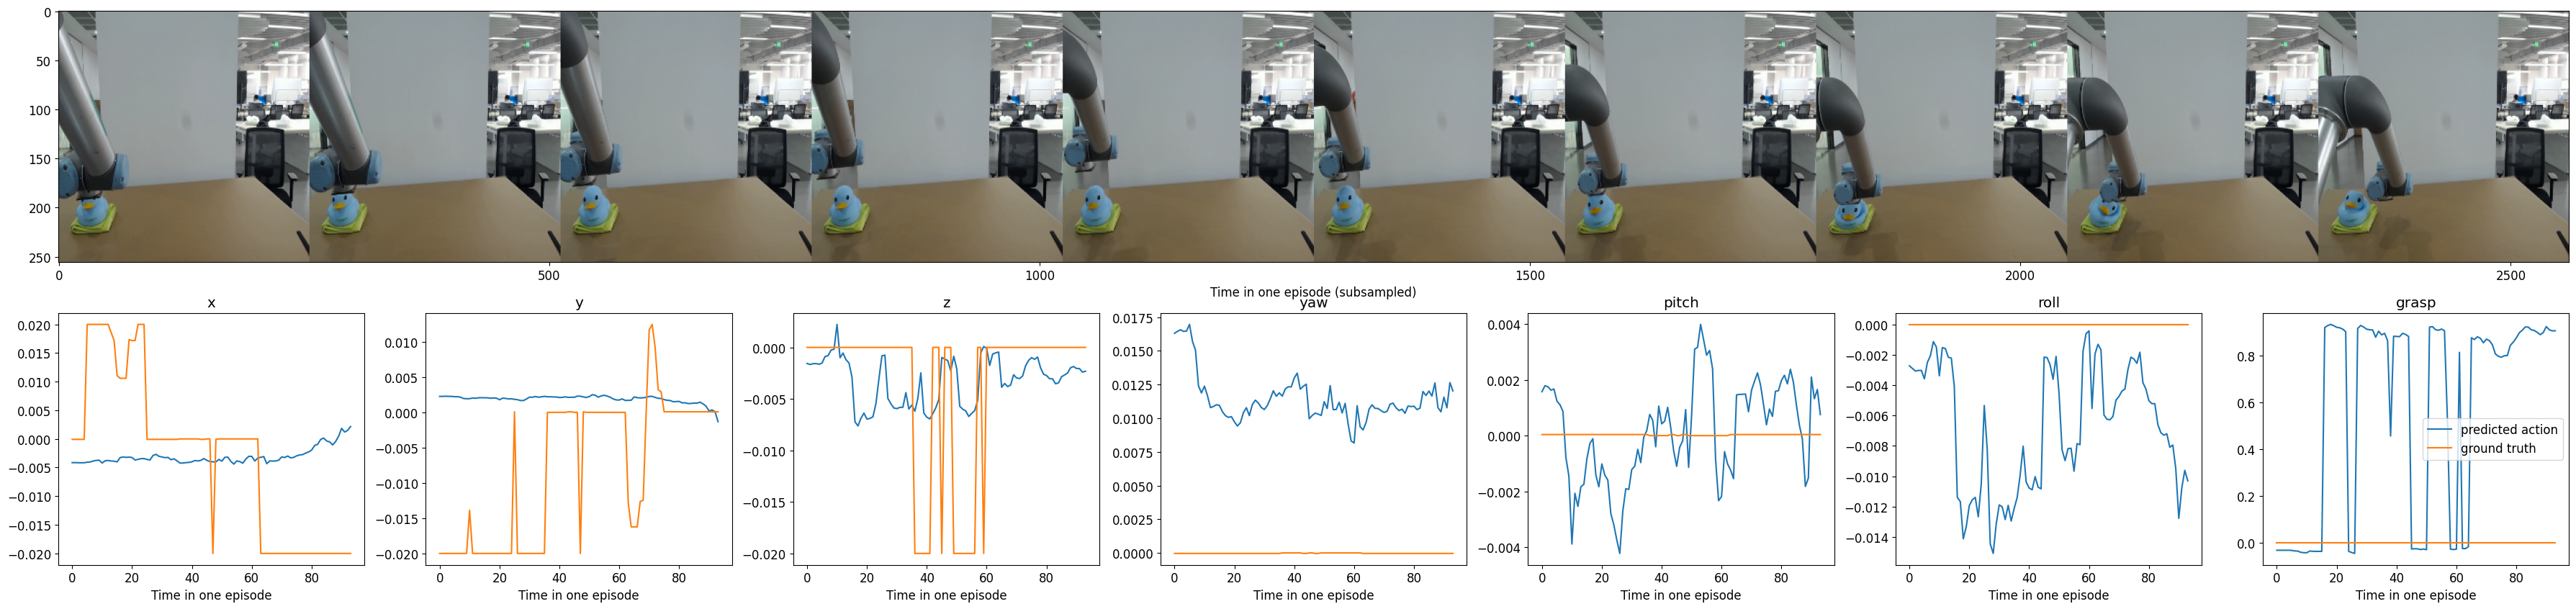

In [19]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::10]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()

## 2. 训练过的模型

In [2]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
from huggingface_hub import hf_hub_download
from octo.model.octo_model import OctoModel
# model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small-1.5")
model = OctoModel.load_pretrained("/root/autodl-tmp/model_duck_big/")
print('Successfully!')

Successfully!


In [3]:
# # create RLDS dataset builder
# builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
# ds = builder.as_dataset(split='train[:1]')
# 创建数据集构建器，使用本地路径
# builder = tfds.builder_from_directory(builder_dir='/root/octo/examples/bridge/0.1.0/')
# builder = tfds.builder_from_directory(builder_dir='/root/autodl-tmp/aloha_sim_dataset/aloha_sim_cube_scripted_dataset/1.0.0/')
builder = tfds.builder_from_directory(builder_dir='/root/autodl-tmp/tensorflow_datasets/duck_killer/1.0.0/')
# 加载数据集
ds = builder.as_dataset(split='val')
print(ds)
# total_images = 0

# for example in ds:
#     steps = list(example['steps'])
#     total_images += len(steps)

# print(f"Total number of images in the dataset: {total_images}")
# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]
# images = images[0:100]
print(len(images))
# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

<_PrefetchDataset element_spec={'episode_metadata': {'file_path': TensorSpec(shape=(), dtype=tf.string, name=None)}, 'steps': DatasetSpec({'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'state': TensorSpec(shape=(12,), dtype=tf.float32, name=None), 'wrist_image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorShape([]))}>
121
Instruction: duck killer


In [4]:
WINDOW_SIZE = 2

# create `task` dict
task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [5]:
# run inference loop, this model only uses 3rd person image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(
        observation, 
        task, 
        unnormalization_statistics=model.dataset_statistics["action"], 
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim
    # print(actions.shape)
    actions = np.concatenate((actions, np.zeros((actions.shape[0],1))), axis=1) 
    # print(actions)
    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(np.concatenate(
        (
            # steps[final_window_step]['action']['world_vector'], 
            # steps[final_window_step]['action']['rotation_delta'], 
            steps[final_window_step]['action'], 
            # np.array(steps[final_window_step]['action']['open_gripper']).astype(np.float32)[None]
            np.zeros(1)
        ), axis=-1
    ))

100%|██████████| 120/120 [00:22<00:00,  5.29it/s]


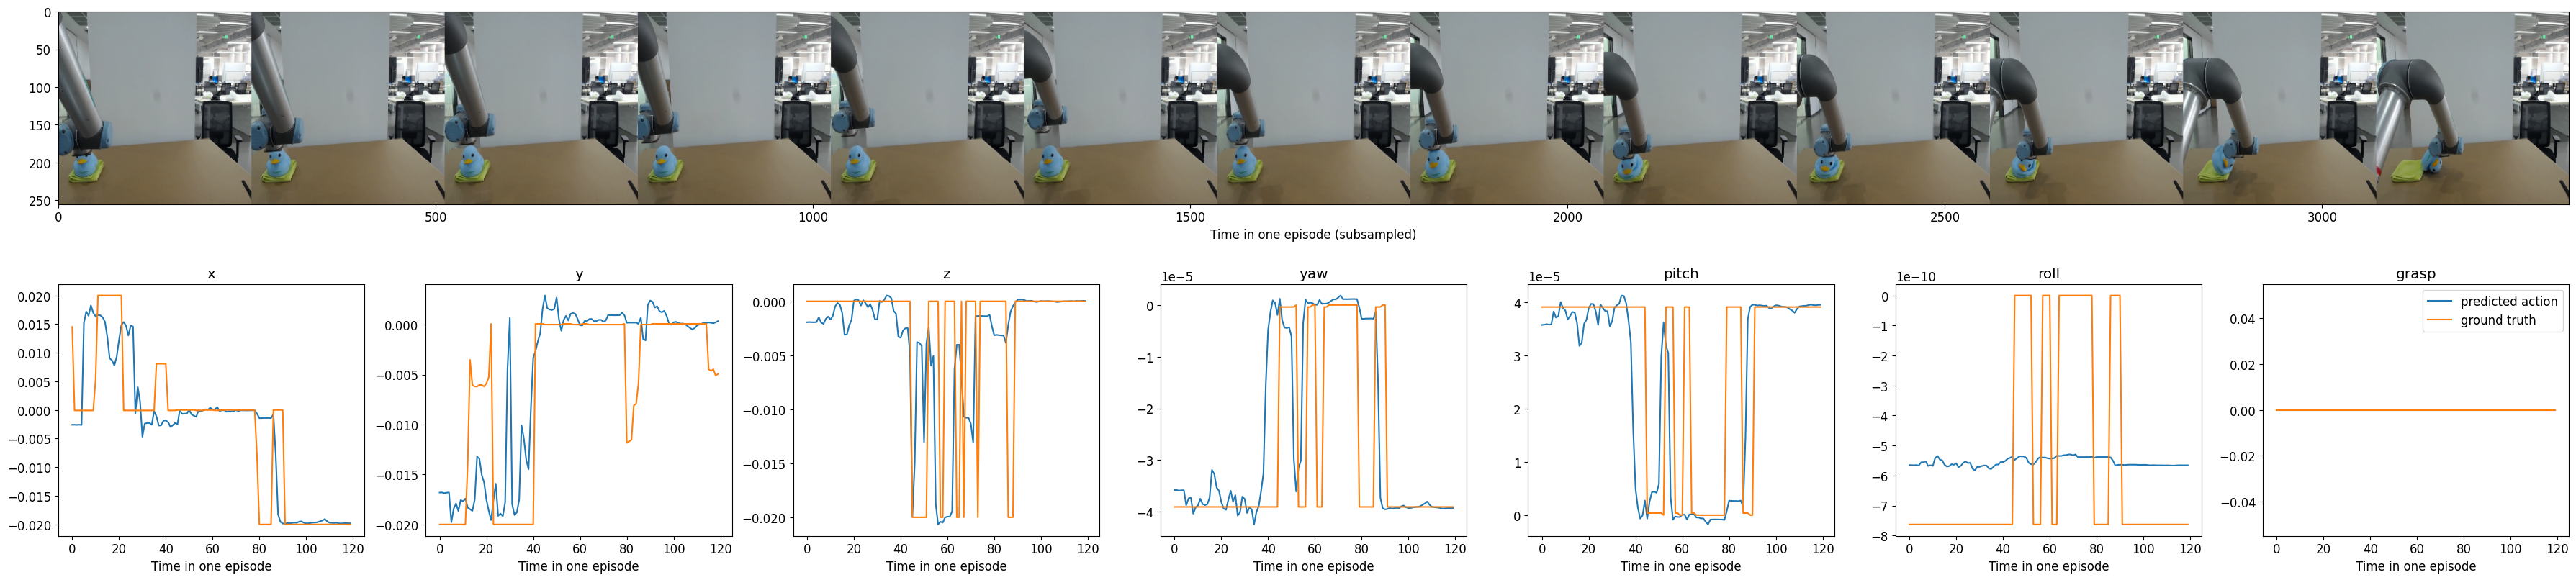

In [6]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::10]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()